In [59]:
import time
from pathlib import Path

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torchvision
import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader

from autoencoder_classes import A64_6
from image_data_helpers import get_data
from plot import draw_apparatus

In [60]:
# modified plotting function

def plot_comparison_ae(reference: np.ndarray, prediction: torch.tensor, model:nn.Module, 
                       out_dir=None, is_square=False, mode='reconstructing', resolution=32): 
    """Create plot comparing the reference data with its autoencoder reconstruction.

    Args:
        reference (np.ndarray): Reference dataset.
        prediction (torch.tensor): Tensor reshaped to match the encoding shape.
        model (nn.Module): Autoencoder model whose decoder used to make predictions.
        out_dir (Path, optional): Output directory. Defaults to None.
        is_square (bool, optional): Switch for square image and full rectangle.
            Defaults to False.
        mode (str, optional): Switch for 'reconstructing' or 'predicting' (plots title). 
            Defaults to 'reconstructing'.

    Returns:
        float: Evaluation time.
        scores: List of reconstruction MSE
    """
    if is_square:
        figsize = (6, 3)
        extent = [0, 20, 35, 55]
    else:
        figsize = (10, 5)
        extent =[0, 20, 0, 70.7]

    extent = [0, 20, 35, 55]

    fig = plt.figure(dpi=300, layout='constrained')
    
    grid = ImageGrid(fig, 111,  # similar to fig.add_subplot(142).
                     nrows_ncols=(2, 5), axes_pad=0.0, label_mode="L", share_all=True,
                     cbar_location="right", cbar_mode="single", cbar_size="5%", cbar_pad='5%')

    with torch.no_grad():
        start = time.time_ns()
        decoded = model.decoder(prediction).cpu().numpy()
        reconstruction = decoded[:, :, :resolution, :resolution]  # assumes shape: (samples, channels, height, width)
        end = time.time_ns()

    # get the larger value between maxima of each dataset
    cbar_ranges = (0, max(reference[0].max(), reconstruction[0].max()))

    eval_time = round((end-start)/1e-6, 2)

    vmin, vmax = cbar_ranges
    print(f"VMAX = {vmax}\n")

    # plot the figures
    for i, ax in enumerate(grid):
        if i <= 4:
            j = i
            org = ax.imshow(reference[0, i, :, :], origin='lower', extent=extent, aspect='equal',
                            vmin=vmin, vmax=vmax, cmap='magma')
            draw_apparatus(ax)
            ax.set_ylabel('z [cm]', fontsize=8)
        else:
            j = i-5
            rec = ax.imshow(reconstruction[0, i-5, :, :], origin='lower', extent=extent, aspect='equal',
                            vmin=vmin, vmax=vmax, cmap='magma')
            draw_apparatus(ax)
            ax.set_ylabel('z [cm]', fontsize=8)
            ax.set_xlabel('r [cm]', fontsize=8)
    
    grid.cbar_axes[0].colorbar(rec)

    # set font sizes and tick stuff
    for ax in grid:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(3))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(2))

        ax.yaxis.set_major_locator(ticker.MaxNLocator(3))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
        ax.tick_params(axis='both', labelsize=8)

    if out_dir is not None:
        fig.savefig(out_dir/f'test_comparison1.png', bbox_inches='tight')

    return fig, eval_time

In [61]:
ncfile = Path('/Users/jarl/2d-discharge-nn/data/interpolation_datasets/synthetic/synthetic_averaged.nc')
ds = xr.open_dataset(ncfile, chunks={'images':62})
data_dir = ncfile.parent
resolution = 64

In [62]:
# load model
device = torch.device('mps' if torch.backends.mps.is_available() 
                        else 'cpu')
model = A64_6().to(device)
model.load_state_dict(torch.load(data_dir/'synthetic_test'))
model.eval()

A64_6(
  (encoder): Sequential(
    (0): Conv2d(5, 10, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(20, 40, kernel_size=(1, 1), stride=(2, 2))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(40, 40, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(40, 20, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(20, 10, kernel_size=(5, 5), stride=(2, 2))
    (7): ReLU()
    (8): Conv2d(10, 5, kernel_size=(1, 1), stride=(1, 1))
    (9): ReLU()
  )
)

In [63]:
# load test data
_, test_res = get_data((300, 60), 
                        resolution=resolution, 
                        square=True)

VMAX = 0.49136465787887573



/Users/jarl/miniconda3/envs/torch/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/Users/jarl/miniconda3/envs/torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


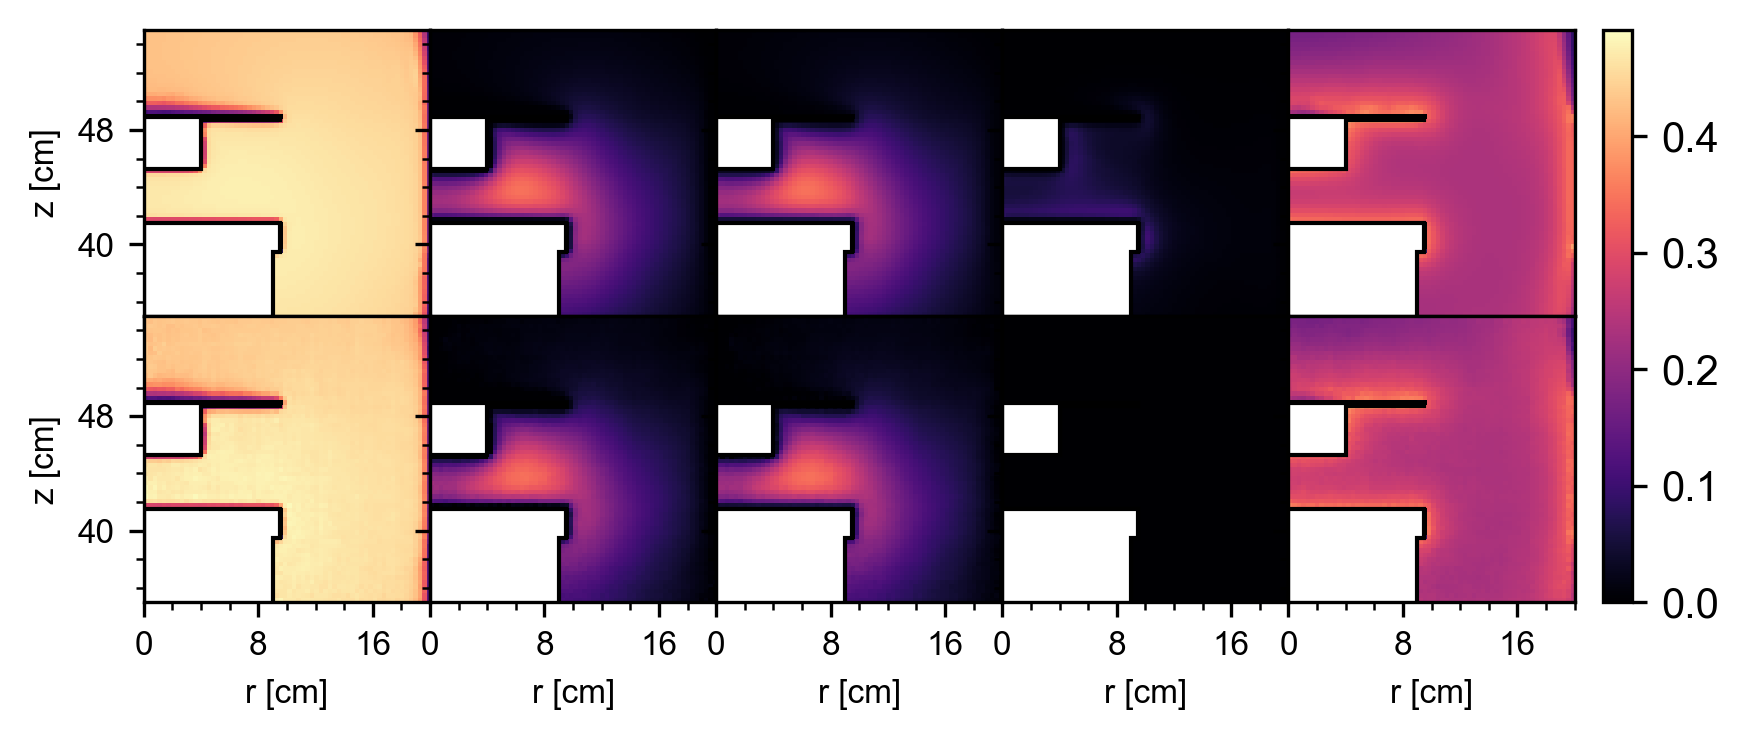

In [64]:
with torch.no_grad():
        encoded = model.encoder(torch.tensor(test_res, device=device, dtype=torch.float32))
        decoded = model.decoder(encoded).cpu().numpy()

fig, _ = plot_comparison_ae(test_res, encoded, model, is_square=True, resolution=64)

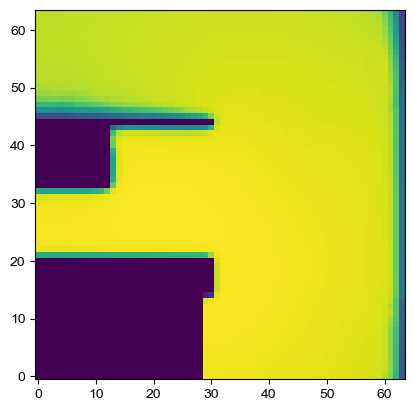

In [65]:
plt.imshow(test_res[0, 0], origin='lower')

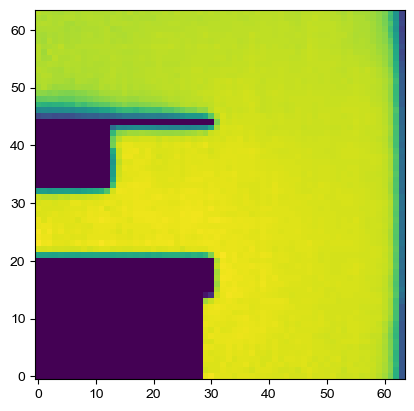

In [66]:
plt.imshow(decoded[0, 0, :64, :64], origin='lower')